In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from word2vec_selection.classes import Word2VecModel

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [79]:
from word2vec_selection.functions import *
model_w2v_settings = return_best_model()

In [80]:
model_w2v = Word2VecModel(model_w2v_settings)

In [81]:
# read preprocessed data from pickle file
df = pd.read_pickle('data/preprocessed_titles_labels.pkl')
df.head()

,title,is_clickbait,text,dataset,sample
0,"[seventeen, time, game, throne, matched, perfe...",1,NaN,clickbait-dataset,train
1,"[facing, texas, tar, heel, territory, duke, fi...",0,NaN,clickbait-dataset,train
2,"[several, gop, state, move, block, funding, sa...",0,A number of GOP states have moved to introduce...,clickbait-news-detection,train
3,"[hillary, clinton, john, kerry, divergent, pat...",0,"WASHINGTON — Early in 2011, after a hectic ...",fake-news,train
4,"[wikinews, interview, kevin, baugh, president,...",0,NaN,clickbait-dataset,train


In [82]:
df['sample'].value_counts()


train    66664
test      3703
val1      1852
val2      1852
Name: sample, dtype: int64

In [83]:
# split data into train and test stratified by y
from sklearn.preprocessing import StandardScaler
import os

df['title_vector'] = [get_word_vectors(model_w2v, title, aggregation='mean') for title in df['title']]

X_train = np.vstack(df[df['sample']=='train']['title_vector'])
X_test = np.vstack(df[df['sample']=='val2']['title_vector'])



y_train = df[df['sample']=='train']['is_clickbait']
y_test = df[df['sample']=='val2']['is_clickbait']

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [84]:
import json

# if file does not exist write empty dict
if not os.path.exists('grid_search_results.json'):
    with open('grid_search_results.json', 'w') as f:
        json.dump({}, f)

with open('grid_search_results.json', 'r') as f:
    model_settings = json.load(f)

model_settings
grids = model_settings['grid_search_grids']
grids

{'decision_tree_grid': {'max_depth': [None, 3, 4, 5, 6, 7, 8],
  'max_features': ['sqrt', 'log2', None]},
 'catboost_grid': {'iterations': [100, 250, 500, 750, 1000],
  'learning_rate': [None, 0.001, 0.01, 0.1, 0.2, 0.3],
  'depth': [3, 4, 5, 6, 7, 8],
  'l2_leaf_reg': [1, 3, 5, 7, 9]},
 'lightgbm_grid': {'n_estimators': [10, 25, 50, 100, 250],
  'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
  'max_depth': [-1, 3, 4, 5, 6, 7, 8],
  'num_leaves': [15, 31, 62, 93, 124]},
 'xgboost_grid': {'n_estimators': [10, 25, 50, 100, 250],
  'learning_rate': [None, 0.001, 0.01, 0.1, 0.2, 0.3],
  'max_depth': [None, 3, 4, 5, 6, 7, 8],
  'gamma': [None, 0, 0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4, 5]},
 'random_forest_grid': {'n_estimators': [50, 100, 250, 750, 1000],
  'max_depth': [None, 3, 4, 5, 6, 7, 8],
  'max_features': ['sqrt', 'log2', None]}}

In [85]:
models_to_CV = list()

for model_name, grid in grids.items():
    # check if model has already been trained - if 'best_params' exists in grid
    if 'best_params' in grid.keys():
        print(f'Model {model_name} already trained')
        continue
    models_to_CV.append((model_name))
models_to_CV

# remove _grid from model names
models_to_CV = [model_name.replace('_grid', '') for model_name in models_to_CV]
models_to_CV

['decision_tree', 'catboost', 'lightgbm', 'xgboost', 'random_forest']

In [86]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [100]:
def return_model_with_param(model_name, param):
    if model_name == 'decision_tree':
        model = DecisionTreeClassifier(**param)
    elif model_name == 'random_forest':
        model = RandomForestClassifier(**param)
    elif model_name == 'xgboost':
        model = XGBClassifier(**param)
    elif model_name == 'lightgbm':
        model = LGBMClassifier(**param, verbose=-1)
    elif model_name == 'catboost':
        model = CatBoostClassifier(**param,verbose=0)
    return model

In [101]:
models_to_CV = ['lightgbm', 'decision_tree',   'xgboost', 'random_forest','catboost',]

In [102]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from tqdm.notebook import tqdm

grid_search_results = dict()
for model_name in models_to_CV:
    grid_search_results[model_name] = dict()

for model_name in tqdm(models_to_CV, desc = 'Models'):

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # get grid
    grid = grids[model_name+'_grid']

    # generate all combinations of parameters
    import itertools

    keys, values = zip(*grid.items())
    combinations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # do grid search
    
    for params in combinations_dicts:
        grid_search_results[model_name][str(params)] = dict()

    for params in tqdm(combinations_dicts, desc = 'Grid combinations search for model {}'.format(model_name)):
        model = return_model_with_param(model_name, params)
        scores_auc_cv_val = list()
        scores_auc_val2 = list()
        scores_auc_train = list()

        scores_f1_cv_val = list()
        scores_f1_val2 = list()
        scores_f1_train = list()

        for train_index, val_index in kf.split(X_train_scaled, y_train):
            X_train_kf = X_train_scaled[train_index]
            X_val_kf = X_train_scaled[val_index]
            y_train_kf = y_train.iloc[train_index]
            y_val_kf = y_train.iloc[val_index]
            model.fit(X_train_kf, y_train_kf)
        
            scores_auc_cv_val.append(roc_auc_score(y_val_kf, model.predict_proba(X_val_kf)[:,1]))
            scores_auc_val2.append(roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))
            scores_auc_train.append(roc_auc_score(y_train_kf, model.predict_proba(X_train_kf)[:,1]))

            scores_f1_cv_val.append(f1_score(y_val_kf, model.predict(X_val_kf)))
            scores_f1_val2.append(f1_score(y_test, model.predict(X_test_scaled)))
            scores_f1_train.append(f1_score(y_train_kf, model.predict(X_train_kf)))

        
        grid_search_results[model_name][str(params)]['mean_train_f1'] = np.mean(scores_f1_train)
        grid_search_results[model_name][str(params)]['mean_cv_val_f1'] = np.mean(scores_f1_cv_val)
        grid_search_results[model_name][str(params)]['mean_val2_f1'] = np.mean(scores_f1_val2)

        grid_search_results[model_name][str(params)]['mean_train_auc'] = np.mean(scores_auc_train)
        grid_search_results[model_name][str(params)]['mean_cv_val_auc'] = np.mean(scores_auc_cv_val)
        grid_search_results[model_name][str(params)]['mean_val2_auc'] = np.mean(scores_auc_val2)

        grid_search_results[model_name][str(params)]['f1_diff_cv_val'] = np.mean(scores_f1_train) - np.mean(scores_f1_cv_val)
        grid_search_results[model_name][str(params)]['auc_diff_cv_val'] = np.mean(scores_auc_train) - np.mean(scores_auc_cv_val)

        grid_search_results[model_name][str(params)]['f1_diff_val2'] = np.mean(scores_f1_train) - np.mean(scores_f1_val2)
        grid_search_results[model_name][str(params)]['auc_diff_val2'] = np.mean(scores_auc_train) - np.mean(scores_auc_val2)

        grid_search_results[model_name][str(params)]['params'] = params


    print(grid_search_results[model_name])
grid_search_results

Models:   0%|          | 0/5 [00:00<?, ?it/s]

Grid combinations search for model lightgbm:   0%|          | 0/875 [00:00<?, ?it/s]

{"{'n_estimators': 10, 'learning_rate': 0.001, 'max_depth': -1, 'num_leaves': 15}": {'mean_train_f1': 0.0, 'mean_cv_val_f1': 0.0, 'mean_val2_f1': 0.0, 'mean_train_auc': 0.8129092798469089, 'mean_cv_val_auc': 0.8092741866932569, 'mean_val2_auc': 0.8128050843627508, 'f1_diff_cv_val': 0.0, 'auc_diff_cv_val': 0.003635093153651958, 'f1_diff_val2': 0.0, 'auc_diff_val2': 0.00010419548415807611, 'params': {'n_estimators': 10, 'learning_rate': 0.001, 'max_depth': -1, 'num_leaves': 15}}, "{'n_estimators': 10, 'learning_rate': 0.001, 'max_depth': -1, 'num_leaves': 31}": {'mean_train_f1': 0.0, 'mean_cv_val_f1': 0.0, 'mean_val2_f1': 0.0, 'mean_train_auc': 0.8302107463160441, 'mean_cv_val_auc': 0.823960625512225, 'mean_val2_auc': 0.8246250306901342, 'f1_diff_cv_val': 0.0, 'auc_diff_cv_val': 0.006250120803819037, 'f1_diff_val2': 0.0, 'auc_diff_val2': 0.005585715625909926, 'params': {'n_estimators': 10, 'learning_rate': 0.001, 'max_depth': -1, 'num_leaves': 31}}, "{'n_estimators': 10, 'learning_rate':

Grid combinations search for model decision_tree:   0%|          | 0/21 [00:00<?, ?it/s]

{"{'max_depth': None, 'max_features': 'sqrt'}": {'mean_train_f1': 0.9997140462751333, 'mean_cv_val_f1': 0.6601292194294268, 'mean_val2_f1': 0.6777029975759017, 'mean_train_auc': 0.9999998876477576, 'mean_cv_val_auc': 0.7162565458996841, 'mean_val2_auc': 0.7343132189278424, 'f1_diff_cv_val': 0.33958482684570646, 'auc_diff_cv_val': 0.2837433417480735, 'f1_diff_val2': 0.3220110486992316, 'auc_diff_val2': 0.2656866687199152, 'params': {'max_depth': None, 'max_features': 'sqrt'}}, "{'max_depth': None, 'max_features': 'log2'}": {'mean_train_f1': 0.9997140462751333, 'mean_cv_val_f1': 0.6690942990240053, 'mean_val2_f1': 0.676455492174538, 'mean_train_auc': 0.9999998876477576, 'mean_cv_val_auc': 0.7233464342670329, 'mean_val2_auc': 0.7329541803932489, 'f1_diff_cv_val': 0.33061974725112797, 'auc_diff_cv_val': 0.27665345338072467, 'f1_diff_val2': 0.32325855410059523, 'auc_diff_val2': 0.2670457072545087, 'params': {'max_depth': None, 'max_features': 'log2'}}, "{'max_depth': None, 'max_features': N

Grid combinations search for model xgboost:   0%|          | 0/2310 [00:00<?, ?it/s]

{"{'n_estimators': 10, 'learning_rate': None, 'max_depth': None, 'gamma': None}": {'mean_train_f1': 0.7685867117503109, 'mean_cv_val_f1': 0.7416950009850698, 'mean_val2_f1': 0.7411630264062211, 'mean_train_auc': 0.899791880780384, 'mean_cv_val_auc': 0.8798086750116798, 'mean_val2_auc': 0.8778372647242406, 'f1_diff_cv_val': 0.026891710765241106, 'auc_diff_cv_val': 0.01998320576870416, 'f1_diff_val2': 0.027423685344089788, 'auc_diff_val2': 0.02195461605614335, 'params': {'n_estimators': 10, 'learning_rate': None, 'max_depth': None, 'gamma': None}}, "{'n_estimators': 10, 'learning_rate': None, 'max_depth': None, 'gamma': 0}": {'mean_train_f1': 0.7685867117503109, 'mean_cv_val_f1': 0.7416950009850698, 'mean_val2_f1': 0.7411630264062211, 'mean_train_auc': 0.899791880780384, 'mean_cv_val_auc': 0.8798086750116798, 'mean_val2_auc': 0.8778372647242406, 'f1_diff_cv_val': 0.026891710765241106, 'auc_diff_cv_val': 0.01998320576870416, 'f1_diff_val2': 0.027423685344089788, 'auc_diff_val2': 0.0219546

Grid combinations search for model random_forest:   0%|          | 0/105 [00:00<?, ?it/s]

In [ ]:
# save results
with open('grid_search_results_new.json', 'w') as f:
    json.dump(grid_search_results, f)

In [ ]:
models = list()
for model in grids:
    models.append(model)
models

['decision_tree_grid',
 'catboost_grid',
 'lightgbm_grid',
 'xgboost_grid',
 'random_forest_grid']

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost')


In [ ]:
# order grids by roc_auc descending
grids = {k: v for k, v in sorted(grids.items(), key=lambda item: item[1]['roc_auc'], reverse=True)}

# get model ranking
model_ranking_auc = list()
for model_name, grid in grids.items():
    model_ranking_auc.append((model_name, grid['roc_auc']))

model_ranking_auc 

[('catboost_grid', 0.9023705609240388),
 ('xgboost_grid', 0.8995354643585243),
 ('lightgbm_grid', 0.8995012624180527),
 ('random_forest_grid', 0.8969251234018227),
 ('decision_tree_grid', 0.8189227121650197)]

In [ ]:
# order grids by f1 descending
grids = {k: v for k, v in sorted(grids.items(), key=lambda item: item[1]['f1'], reverse=True)}

# get model ranking
model_ranking_f1 = list()
for model_name, grid in grids.items():
    model_ranking_f1.append((model_name, grid['f1']))

model_ranking_f1 

[('lightgbm_grid', 0.7736263736263737),
 ('catboost_grid', 0.7636632200886263),
 ('xgboost_grid', 0.7626745040411463),
 ('random_forest_grid', 0.7557879014189695),
 ('decision_tree_grid', 0.6853677028051555)]

# WINNER - lightgbm

In [ ]:
# get params for best model
best_model = model_ranking_auc[1][0]
best_params = grids[best_model]['best_params']
best_model, best_params

('xgboost_grid',
 {'gamma': 0.001, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200})

In [ ]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(max_depth= -1, n_estimators=500, num_leaves= 155, learning_rate= 0.1)
clf.fit(X_train_scaled, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:, 1])
f1 = f1_score(y_test, clf.predict(X_test_scaled))

print(f'ROC AUC: {roc_auc}')
print(f'F1: {f1}')

ROC AUC: 0.8995012624180527
F1: 0.7736263736263737


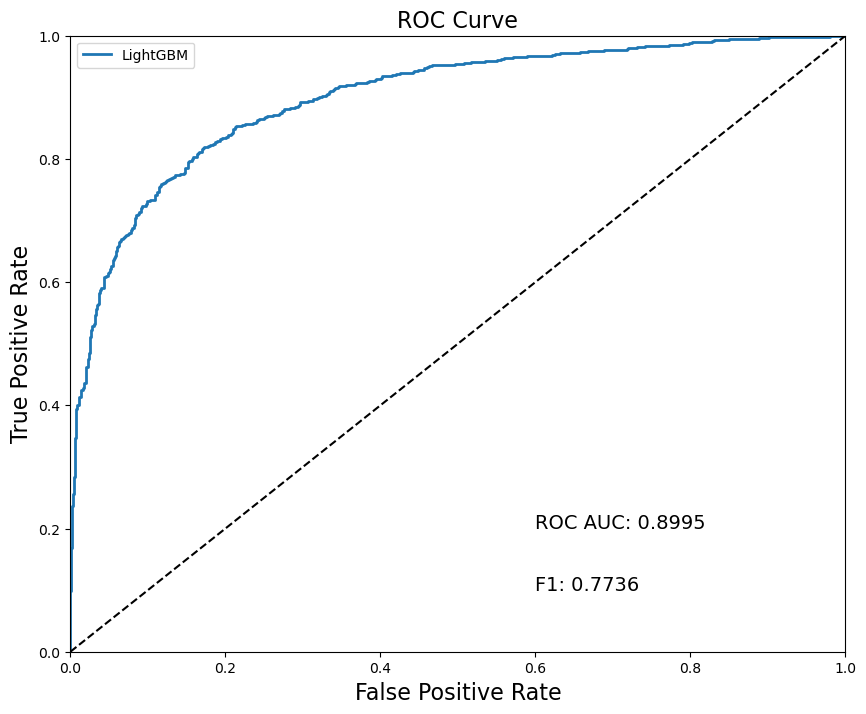

In [ ]:
from sklearn.metrics import roc_curve

# plot ROC curve    
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label='LightGBM')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve', fontsize=16)
# add info about roc_auc and f1
plt.text(0.6, 0.2, f'ROC AUC: {roc_auc:.4f}', fontsize=14)
plt.text(0.6, 0.1, f'F1: {f1:.4f}', fontsize=14)

plt.legend()
plt.show()

In [ ]:
# print confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, clf.predict(X_test_scaled))


array([[1015,  108],
       [ 201,  528]])

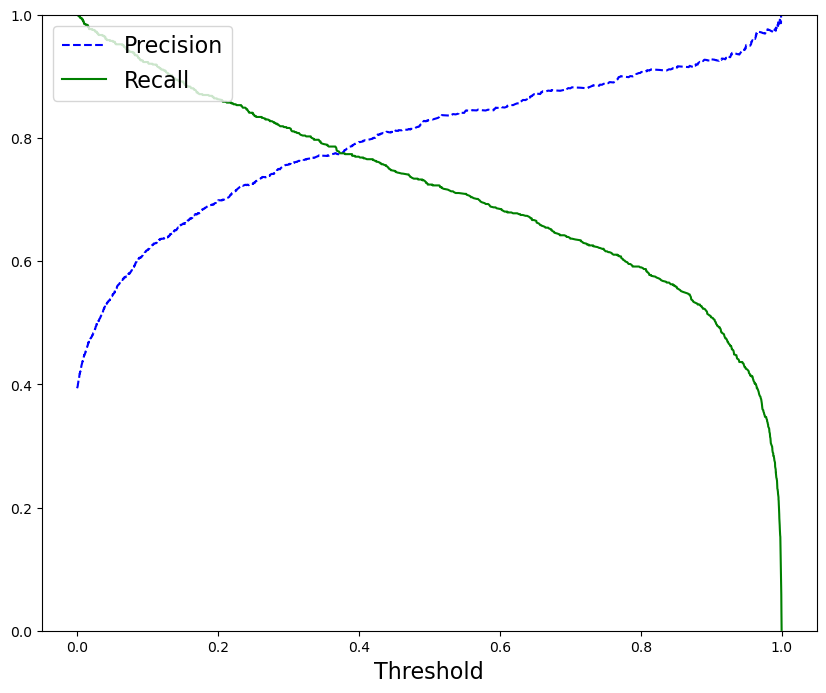

In [ ]:
# find best threshold
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold', fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.ylim([0, 1])
plt.show()


In [ ]:
# get the point at which precision and recall are equal
threshold = thresholds[np.argmax(precisions == recalls)]
threshold

0.3749938102239996

In [ ]:
# get predictions for test data with best threshold
y_pred = (clf.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)

# print confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)


array([[959, 164],
       [164, 565]])

In [ ]:
# print f1 score
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

0.7750342935528121

In [ ]:
import numpy as np
from tqdm.auto import tqdm
# find threshold for best f1 score
thresholds = np.linspace(0, 1, 10000)
f1s = dict()
for threshold in tqdm(thresholds):
    y_pred = (clf.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1s[threshold] = f1

# get threshold for best f1 score
threshold = max(f1s, key=f1s.get)
threshold
    

  0%|          | 0/10000 [00:00<?, ?it/s]

0.30123012301230123

In [ ]:
# find auc and f1 for best threshold
y_pred = (clf.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print(f'ROC AUC: {roc_auc}')
print(f'F1: {f1}')

ROC AUC: 0.8995012624180527
F1: 0.785997357992074


In [ ]:
# save clf to pickle file
import pickle

with open('predictive_models/lightgbm.pkl', 'wb') as f:
    pickle.dump(clf, f)

# save scaler to pickle file
with open('predictive_models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
# save threshold to txt file
with open('predictive_models/threshold.txt', 'w') as f:
    f.write(str(threshold))